# Object Detection Pytorch

In [1]:
import determined as det
import os
import torch
import torchvision
from tqdm.notebook import trange, tqdm
import numpy as np

# Building a Model

We'll start by building a model trained to do pedestrian detection (details)

In [2]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Data Loading

In [3]:
from data import download_data, PennFudanDataset, get_transform, collate_fn

data_url = "https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip"
download_directory = "./data/"
download_data(
    download_directory=download_directory, 
    data_config={"url": data_url},
)

In [4]:
from torch.utils.data import DataLoader

dataset = PennFudanDataset(download_directory + "/PennFudanPed", get_transform())

# Split 80/20 into training and validation datasets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_val = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(dataset_train, batch_size=2, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=2, collate_fn=collate_fn, shuffle=False)

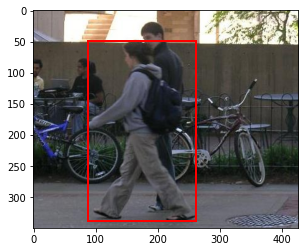

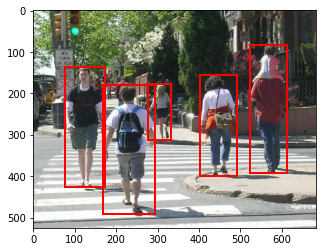

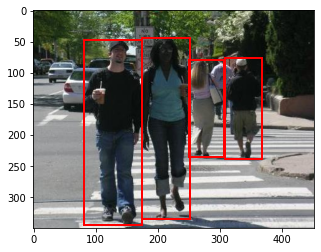

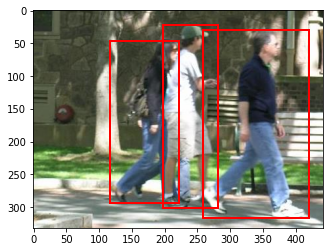

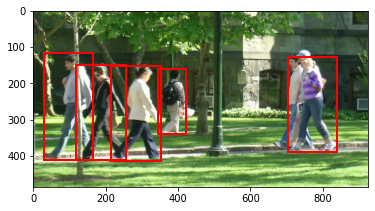

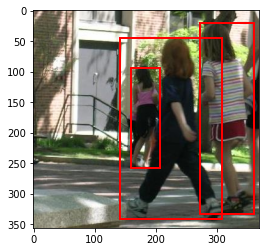

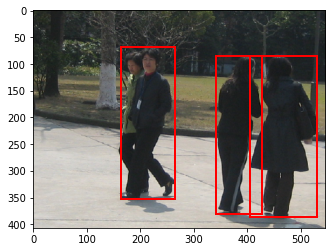

IndexError: too many indices for tensor of dimension 1

In [17]:
from data import draw_example
for images, labels in val_loader:
    image = images[0]
    label = labels[0]
    draw_example(image.permute(1,2,0).numpy(), label)
    
    

## Training your Model

In [6]:
lr = 0.005
momentum = 0.9
decay =  0.0005

In [32]:
optimizer = torch.optim.SGD(
                model.parameters(),
                lr=lr,
                momentum=momentum,
                weight_decay=decay,
            )

NUM_EPOCHS=1
for _ in range(NUM_EPOCHS):
    train_loop = tqdm(train_loader)
    for images, targets in train_loop:
        optimizer.zero_grad()
        losses = model(list(images), list(targets))
        total_loss = sum([losses[l] for l in losses])
        total_loss.backward()
        optimizer.step()


TypeError: list indices must be integers or slices, not dict

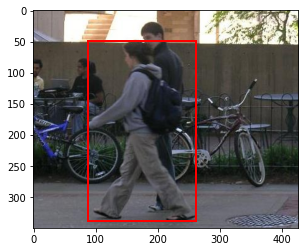

In [30]:
model.eval()
import copy
for images, targets in val_loader:
    with torch.no_grad():
        output = model(list(images), copy.deepcopy(list(targets)))
        image = images[0]
        target = targets[0]
        
        draw_example(image.permute(1,2,0).numpy(), target)
        
    break


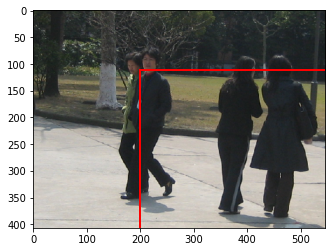

tensor([[198.8571, 112.0000, 596.5715, 772.5715]])
tensor([[0.0000e+00, 1.2102e+02, 1.2257e+01, 1.3983e+02],
        [4.3934e-01, 1.0910e+02, 1.3932e+01, 1.7782e+02],
        [5.2435e-02, 1.0007e+02, 1.0894e+01, 1.4263e+02],
        [3.4834e+02, 1.6916e+02, 3.8589e+02, 2.6902e+02],
        [2.7575e+02, 6.1932e+01, 3.9816e+02, 2.9674e+02],
        [3.0629e+02, 1.3186e+02, 4.0162e+02, 2.5364e+02],
        [1.7248e+02, 4.5262e+01, 4.1752e+02, 2.8061e+02],
        [1.4209e+02, 7.5919e+01, 2.3798e+02, 3.0116e+02],
        [6.0976e+01, 1.0051e+02, 1.5421e+02, 2.9027e+02],
        [1.6153e+02, 1.6563e+00, 3.1455e+02, 3.2126e+02],
        [4.7293e-01, 1.0331e+02, 2.3743e+01, 1.8597e+02],
        [2.3420e+01, 1.2304e+02, 1.2937e+02, 2.7984e+02],
        [2.1050e+00, 8.2573e+01, 2.0241e+01, 1.4388e+02],
        [2.5952e+02, 1.8493e+02, 3.7044e+02, 2.8143e+02],
        [7.5012e+01, 1.0923e+02, 1.2465e+02, 1.6917e+02],
        [3.2792e+02, 1.7353e+02, 4.0867e+02, 2.7435e+02]])


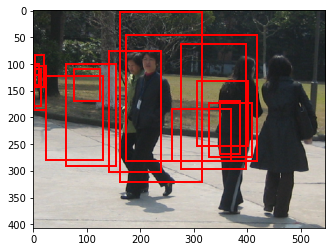

In [20]:
# Filter out overlapping bounding box predictions based on
# non-maximum suppression (NMS)
idx=0
predicted_boxes = output[idx]["boxes"]
prediction_scores = output[idx]["scores"]
keep_indices = torchvision.ops.nms(predicted_boxes, prediction_scores, 0.1)
predicted_boxes = torch.index_select(predicted_boxes, 0, keep_indices)
prediction_scores = torch.index_select(prediction_scores, 0, keep_indices)


# Tally IoU with respect to the ground truth target boxes
image = images[idx]
target = targets[idx]
draw_example(image.permute(1,2,0).numpy(), target)

target_boxes = target["boxes"]

boxes_iou = torchvision.ops.box_iou(target_boxes, predicted_boxes)
# print(boxes_iou)
# sum_iou += sum(max(iou_result) for iou_result in boxes_iou)
# num_boxes += len(target_boxes)

# boxes are ordered by confidence, so get the top 5 bounding boxes and write out to Tensorboard
# new_predicted_boxes = output[idx]["boxes"][:5]
threshold = 0.5
for i, score in enumerate(prediction_scores):
    if score < threshold:
        break
    cutoff = i
new_predicted_boxes = output[idx]["boxes"][:cutoff]

print(target_boxes)
print(new_predicted_boxes)
draw_example(image.permute(1,2,0).numpy(), {'boxes': new_predicted_boxes})


## What next?

As you get into scaled experimentation, you end up needing to iterate on the following in a variety of ways.

## ~change data source~

## ~implement single GPU hyperparameter search~

## ~implement package / code for parallel hyperparameter search~

## ~implement package / code for single node distributed training~

## ~build cluster for multi-node distributed training~

## ~update code for multi-node distributed training~

## ~implement fault tolerance and cloud checkpointing~

## ~implement Tensorboard with multi-node training~

# Scaled Experimentation

In an ideal scenario, though, you should be able to execute the code on a GPU in a cluster just as easily, from your local computer.

## Configure your Experiment

With Determined, you simply need to describe the experiment you'd like to conduct.  Here we'll specify a simple, single GPU training with fixed hyperparameters.  Instructions for how to configure different types of experiments [can be found in the Determined documentation.](https://docs.determined.ai/latest/how-to/index.html)

In [54]:
import yaml

config = {
    "description": "pedestrian_detection_single_gpu",
    "data": { 
        "url": "https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip"
    },
    "hyperparameters": {
        "learning_rate": 0.005,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "global_batch_size": 2,
    },
    "searcher": {
        "name": "single",
        "metric": "val_avg_iou",
        "max_steps": 20,
        "smaller_is_better": False,
    },
    "entrypoint": "model_def:ObjectDetectionTrial",
    "min_validation_period": 1,
    "max_restarts": 1,
    "batches_per_step": 20,
}
with open('train.yaml', 'w') as config_file:
   yaml.dump(config, config_file)

## Create your Experiment

Now that you've described your experiment, you'll simply need to use the command line interface to submit it to the Determined Cluster.  

In [32]:
determined_master = 'http://ec2-44-232-98-31.us-west-2.compute.amazonaws.com:8080'

In [56]:
!det -m {determined_master} experiment create train.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 601.3KB and 13 files
Created experiment 24


## Scaling up to Distributed Training

Determined makes it trivial to move from single-GPU to multi-GPU (and even multi-node) training. Here we'll simply modify the config above to request 8 GPUs instead of 1, and increase the global batch size to increase the data throughput 

In [57]:
distributed_config = config
distributed_config['resources'] = {'slots_per_trial': 8}
distributed_config['hyperparameters']['global_batch_size'] = 16
distributed_config['description'] = "distributed_training"

with open('distributed.yaml', 'w') as config_file:
   yaml.dump(distributed_config, config_file)

In [33]:
!det -m {determined_master} experiment create distributed.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 4.1MB and 14 files 
Created experiment 37


# Adaptive Hyperparameter Search

In [68]:
search_config = config
search_config['resources'] = {'slots_per_trial': 1}
search_config['description'] = "hyperparamter_tuning"

search_config['hyperparameters'] = {
    'learning_rate': {
        'type': 'log',
        'minval': -4,
        'maxval': -1,
        'base': 10,
    },
    'momentum': {
        'type': 'double',
        'minval': 0.7,
        'maxval': 0.95,
    },
    'global_batch_size': 2,
    'weight_decay': .0005,
}

search_config['searcher'] = {
    'name': 'adaptive_simple',
    'metric': 'val_avg_iou',
    'max_steps': 40,
    'smaller_is_better': False,
    'max_trials': 24,
}

with open('search.yaml', 'w') as config_file:
   yaml.dump(search_config, config_file)

## Submit Experiment to Cluster

In [37]:
!det -m {determined_master} experiment create search.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 1.2MB and 14 files  
Created experiment 36


# Multi-Node Distributed Training

In [6]:
!cat -n dist.yaml

     1	description: object_detection_pytorch_const_eval_image
     2	data:
     3	  url: https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip
     4	hyperparameters:
     5	  learning_rate: 0.005
     6	  momentum: 0.9
     7	  weight_decay: 0.0005
     8	  global_batch_size: 2
     9	searcher:
    10	  name: single
    11	  metric: val_avg_iou
    12	  max_steps: 2
    13	  smaller_is_better: false
    14	entrypoint: model_def:ObjectDetectionTrial
    15	min_validation_period: 1
    16	max_restarts: 1
    17	batches_per_step: 100
    18	resources:
    19	  slots_per_trial: 16


## Submit Experiment to Cluster

In [ ]:
!det -m {determined_master} experiment create adaptive.yaml .

# Model Export

In [7]:
# Show model checkpoint exporting and inference code

# Collaboration

In [8]:
# Show collaboration experience in Web UI

# (Optional) Use Determined Native

In [9]:
# Follow the same narrative, but use Native and configurations directly in cell instead of using the CLI

In [16]:
import argparse
import json
import pathlib

from determined import experimental as exp
import determined as det
import model_def

## Select Data

In [74]:
dataset_url = (
    "https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/"
    "PennFudanPed/PennFudanPed.zip"
)

In [75]:
mode = "cluster"

In [88]:
config = {
    "max_restarts": 0,
    "data": {"url": dataset_url},
    "hyperparameters": {
        "learning_rate": det.Constant(value=0.005),
        "momentum": det.Constant(value=0.9),
        "weight_decay": det.Constant(value=0.0005),
        "global_batch_size": det.Constant(value=2),
    },
    "batches_per_step": 1,
    "searcher": {
        "name": "single",
        "metric": "val_avg_iou",
        "max_steps": 8,
        "smaller_is_better": False,
    },
}

In [89]:
exp.create(
    master_url=determined_master,
    trial_def=model_def.ObjectDetectionTrial,
    config=config,
    mode=exp.Mode(mode),
    context_dir="./",
    command=["./Object-Detection-PyTorch.ipynb"],
)

Creating an experiment with config: {'searcher': {'name': 'single', 'metric': 'val_avg_iou', 'max_steps': 8, 'smaller_is_better': False}, 'batches_per_step': 1, 'resources': {'slots_per_trial': 1, 'native_parallel': False}, 'optimizations': {'aggregation_frequency': 1, 'average_aggregated_gradients': True, 'average_training_metrics': False, 'gradient_compression': False, 'mixed_precision': 'O0'}, 'max_restarts': 0, 'data': {'url': 'https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip'}, 'hyperparameters': {'learning_rate': {'type': 'const', 'val': 0.005}, 'momentum': {'type': 'const', 'val': 0.9}, 'weight_decay': {'type': 'const', 'val': 0.0005}, 'global_batch_size': {'type': 'const', 'val': 2}}, 'internal': {'native': {'command': ['./Object-Detection-PyTorch.ipynb']}}}
Preparing files (/Users/hphan/go/src/github.com/determined-ai/determined/examples/official/object_detection_pytorch) to send to master... 69.3KB and 7 files 
Created experiment 

### model_def.py
Standard definition for the model in the framework of choice.

In [7]:
!cat -n model_def.py

     1	"""
     2	This is an object detection finetuning example.  We finetune a Faster R-CNN
     3	model pretrained on COCO to detect pedestrians in the relatively small PennFudan
     4	dataset.
     5	
     6	Useful References:
     7	    https://docs.determined.ai/latest/reference/api/pytorch.html
     8	    https://www.cis.upenn.edu/~jshi/ped_html/
     9	
    10	Based on: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    11	"""
    12	from typing import Any, Dict, Sequence, Union
    13	
    14	import torch
    15	import torchvision
    16	from torch import nn
    17	from torchvision.models.detection import fasterrcnn_resnet50_fpn
    18	from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    19	from torch.utils.tensorboard import SummaryWriter
    20	import numpy as np
    21	
    22	import determined as det
    23	from determined.pytorch import DataLoader, LRScheduler, PyTorchTrial
    24	
    25	from data import download_data, get_tra

### const.yaml
Standard configuration file or command line arguments.

In [35]:
!cat -n const.yaml

     1	description: object_detection_pytorch_const_eval_image
     2	data:
     3	  url: https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip
     4	hyperparameters:
     5	  learning_rate: 0.005
     6	  momentum: 0.9
     7	  weight_decay: 0.0005
     8	  global_batch_size: 2
     9	searcher:
    10	  name: single
    11	  metric: val_avg_iou
    12	  max_steps: 8
    13	  smaller_is_better: false
    14	entrypoint: model_def:ObjectDetectionTrial
    15	min_validation_period: 1
    16	max_restarts: 0


# Early Prototyping

Find a model that is close to the functionality you're looking for.

In [2]:
!git clone <repo> # set <repo> to the PyTorch Object Detection repo

/bin/sh: -c: line 0: syntax error near unexpected token `newline'
/bin/sh: -c: line 0: `git clone <repo> # set <repo> to the PyTorch Object Detection repo'


## View Repo

Most machine learning repositories will contain similar files, including the model definition and configuration files.

In [3]:
!ls <repo>

/bin/sh: -c: line 0: syntax error near unexpected token `newline'
/bin/sh: -c: line 0: `ls <repo>'
